In [2]:
!pip3 install pyro-ppl

     |████████████████████████████████| 713 kB 4.0 MB/s 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
class NN(nn.Module):
  #deterministic neural network
    def __init__(self, i, h, o):
        super(NN, self).__init__()
        #define the input layer
        self.fc1 = nn.Linear(i, h)
        #define the hidden layer
        self.fc2 = nn.Linear(h, o)
        
    def forward(self, x):
        res = self.fc1(x)
        #apply tanh activation function
        res = torch.tanh(res)
        res = self.fc2(res)
        #apply sigmoid activation function
        return torch.squeeze(torch.sigmoid(res))

In [3]:
def train_det(model, X_train, Y_train, X_test, Y_test, lr, epochs, batch):  
    #function that train the deterministic model

    #define the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #define the criterion loss
    criterion = torch.nn.BCEWithLogitsLoss()

    #create batches torch for training and test sets
    b_x_train, b_y_train = torch.split(X_train, batch), torch.split(Y_train, batch)
    b_x_test, b_y_test = torch.split(X_test, batch), torch.split(Y_test, batch)

    #create a list of train losses to plot
    losses_train = []
    #create a list of train accuracy to plot
    scores_train = []
    #create a list of test accuracy to plot
    scores_test = []

    for epoch in range(epochs):
      #iterate through epoches
        train_loss = 0
        no_batches = len(b_x_train)
        #iterate through batches
        for i in range(no_batches):
            optimizer.zero_grad() 

            #get the output of the model for the current batch
            output = model(b_x_train[i])
            #calculate the loss of the batch
            actual_loss = criterion(output, b_y_train[i])
            #add to the total loss
            train_loss += actual_loss

            actual_loss.backward()
            optimizer.step()
        
        #calculate train loss
        train_loss = train_loss / len(X_train)
        train_loss = train_loss.item()
        losses_train.append(train_loss)

        actual_predictions = []
        with torch.no_grad():
            #iterate through train batches
            for batch in b_x_train:
                predicted_labels = model(batch)
                #convert the probability of the sigmoid function to the actual class
                predicted_labels = np.asarray([0 if x < 0.5 else 1 for x in predicted_labels])

                for label in predicted_labels:
                  actual_predictions.append(label)
            #calculate the train accuracy
            train_score = accuracy_score(Y_train.detach().numpy(), actual_predictions)
        train_score = train_score.item()
        scores_train.append(train_score)

        actual_predictions = []
        with torch.no_grad():
          #iterate through test batches
            for batch in b_x_test:
                predicted_labels = model(batch)
                #convert the probability of the sigmoid function to the actual class
                predicted_labels = np.asarray([0 if x < 0.5 else 1 for x in predicted_labels])

                for label in predicted_labels:
                  actual_predictions.append(label)

            #calculate the test accuracy
            test_score = accuracy_score(Y_test.detach().numpy(), actual_predictions)
        test_score = test_score.item()
        scores_test.append(test_score)
        

        print("epoch: {}, train loss: {}, train acc: {}, test acc: {}".format(epoch, train_loss, train_score, test_score))

    #return the train losses and train and test accuracies
    return np.asarray(losses_train), np.asarray(scores_train), np.asarray(scores_test)


In [9]:
#create a dataset with 1000 samples and noise 0.2 using make moons
X, y = make_moons(n_samples=1000, noise=0.2)
#split the dataset into 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)


#convert to torch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [10]:
#define the model
model = NN(2, 8, 1)

#train the model
train_losses, score_train, score_test = train_det(model, X_train, y_train, X_test, y_test, lr=0.05, epochs=70, batch=32)


epoch: 0, train loss: 0.019829628989100456, train acc: 0.82, test acc: 0.855
epoch: 1, train loss: 0.017888953909277916, train acc: 0.8475, test acc: 0.855
epoch: 2, train loss: 0.01769234985113144, train acc: 0.855, test acc: 0.88
epoch: 3, train loss: 0.017676543444395065, train acc: 0.85625, test acc: 0.875
epoch: 4, train loss: 0.017655285075306892, train acc: 0.8575, test acc: 0.875
epoch: 5, train loss: 0.01762234978377819, train acc: 0.86125, test acc: 0.875
epoch: 6, train loss: 0.01754452846944332, train acc: 0.8675, test acc: 0.875
epoch: 7, train loss: 0.017435915768146515, train acc: 0.87625, test acc: 0.895
epoch: 8, train loss: 0.017299789935350418, train acc: 0.895, test acc: 0.91
epoch: 9, train loss: 0.01712421141564846, train acc: 0.91, test acc: 0.925
epoch: 10, train loss: 0.016898255795240402, train acc: 0.92375, test acc: 0.935
epoch: 11, train loss: 0.01670338585972786, train acc: 0.92875, test acc: 0.945
epoch: 12, train loss: 0.01656961999833584, train acc: 0.9

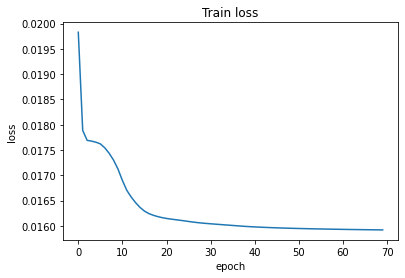

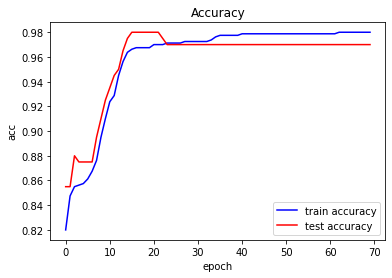

In [11]:
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Train loss')
plt.show()

plt.plot(score_train, '-b', label='train accuracy')
plt.plot(score_test, '-r', label='test accuracy')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [12]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, i, h, o):
        super().__init__()
        #define the first layer
        self.fc1 = PyroModule[nn.Linear](i, h)
        #define the hidden layer
        self.fc2 = PyroModule[nn.Linear](h, o)

        #assume a normal distributions for weight and bias
        self.fc1.weight = PyroSample(dist.Normal(0., 1.)
                                         .expand(self.fc1.weight.shape)
                                         .to_event(self.fc1.weight.dim()))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.)
                                       .expand(self.fc1.bias.shape)
                                       .to_event(self.fc1.bias.dim()))
        
        self.fc2.weight = PyroSample(dist.Normal(0., 1.)
                                         .expand(self.fc2.weight.shape)
                                         .to_event(self.fc2.weight.dim()))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.)
                                       .expand(self.fc2.bias.shape)
                                       .to_event(self.fc2.bias.dim()))
        

    def forward(self, x, y=None):
        #apply relu activation function
        x = F.relu(self.fc1(x))
        #apply sigmoid activation function
        x = torch.sigmoid(self.fc2(x)).squeeze()

        size = x.shape[0]
        #sample from the bernoulli distribution
        with pyro.plate('data', size):
            obs = pyro.sample('obs', dist.Bernoulli(probs=x), obs=y)
        
        return x


In [13]:
def train_bayesian(model, X_train, y_train, X_test, y_test, lr, epochs):  
  #clear parameters store
  pyro.clear_param_store()

  #define the criterion
  criterion = nn.BCELoss()
  #define the adam optimizer
  optimizer_bayes = pyro.optim.Adam({"lr": lr})

  svi = SVI(bayesian_model, guide, optimizer_bayes, loss=Trace_ELBO())

  #create a list of train losses to plot
  losses_bayes = []
  #create a list of train acc to plot
  train_scores = []

  #create a list of test losses to plot
  test_scores = []

  for epoch in range(0, epochs):
      loss = svi.step(X_train, y_train)
      #calculate the training loss
      train_loss = loss / len(X_train)
      losses_bayes.append(train_loss)

      # run on 250 samples extracted from the weights distributions 
      predictive = Predictive(bayesian_model, guide=guide, num_samples=250)
      pred_train_bayes = predictive(X_train)['obs'].median(dim=0)[0].int()
      train_score = (pred_train_bayes == y_train).float().mean()
      #calculate train accuracy
      train_scores.append(train_score)

      # run on 250 samples extracted from the weights distributions 
      pred_test_bayes = predictive(X_test)['obs'].median(dim=0)[0].int()
      test_score = (pred_test_bayes == y_test).float().mean()
      #calculate test accuracy
      test_scores.append(test_score)

      print("epoch: {}, train loss: {}, train acc: {}, test acc: {}".format(epoch, train_loss, train_score, test_score))
  #return the train losses and train and test accuracies
  return np.array(losses_bayes), np.array(train_scores), np.array(test_scores)

In [14]:
#define the model and the guide
bayesian_model = BayesianNeuralNetwork(2, 8, 1)
guide = AutoNormal(bayesian_model)

In [16]:
#train the model
train_losses, score_train, score_test = train_bayesian(bayesian_model, X_train, y_train, X_test, y_test, 0.01, 50)

epoch: 0, train loss: 0.7703393788635731, train acc: 0.5137500166893005, test acc: 0.5350000262260437
epoch: 1, train loss: 0.75565021507442, train acc: 0.5174999833106995, test acc: 0.46000000834465027
epoch: 2, train loss: 0.7692966243624687, train acc: 0.5112500190734863, test acc: 0.4449999928474426
epoch: 3, train loss: 0.764533927962184, train acc: 0.5162500143051147, test acc: 0.47999998927116394
epoch: 4, train loss: 0.7668396843224764, train acc: 0.48750001192092896, test acc: 0.4399999976158142
epoch: 5, train loss: 0.7656305328011512, train acc: 0.5162500143051147, test acc: 0.5299999713897705
epoch: 6, train loss: 0.7706871885061264, train acc: 0.49125000834465027, test acc: 0.5350000262260437
epoch: 7, train loss: 0.7630029348284006, train acc: 0.4962500035762787, test acc: 0.45500001311302185
epoch: 8, train loss: 0.7604612480849028, train acc: 0.5099999904632568, test acc: 0.49000000953674316
epoch: 9, train loss: 0.7556731341034174, train acc: 0.4724999964237213, test a

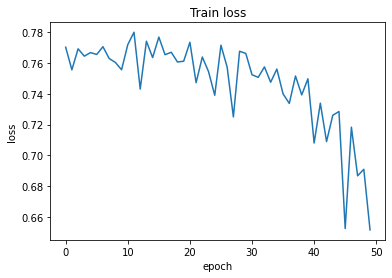

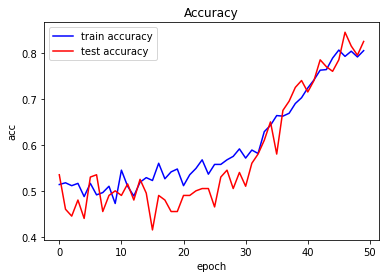

In [17]:
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('Train loss')
plt.show()

plt.plot(score_train, '-b', label='train accuracy')
plt.plot(score_test, '-r', label='test accuracy')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

Conclusions: looking at the train loss and train/test accuracy plot, it can be easily seen that deep learning neural network works better than the bayesian neural network, however it needs more epoches for the deep learning model. It takes a lot of time for the bayesian neural network to train, but looking at the accuracy plot it seems that more epoches gets a better accuracy.